In [2]:
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 14.0 MB/s eta 0:00:0000:0100:01


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

Feed forward

In [4]:
inputs = np.eye(5)
targets = np.random.rand(len(inputs),8)

weights = []
weights.append(np.random.rand(len(inputs[0]), 7))
weights.append(np.random.rand(len(weights[-1][0]), 9))
weights.append(np.random.rand(len(weights[-1][0]), 6))
weights.append(np.random.rand(len(weights[-1][0]), len(targets[0])))
grads = [None for _ in weights]

lr = 0.00025

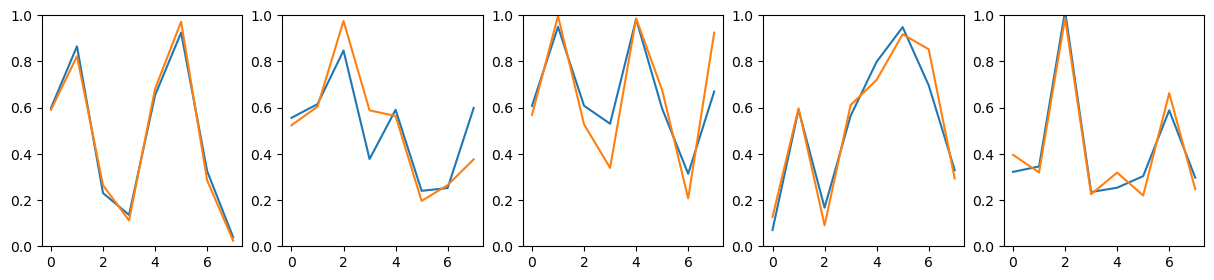

In [5]:
for _ in range(10000):
    layers = [inputs @ weights[0]]
    layers.append(layers[-1] @ weights[1])
    layers.append(layers[-1] @ weights[2])
    layers.append(layers[-1] @ weights[3])
    

    err = (layers[-1]-targets)
    grads[3] = np.einsum('ab,ac->bc',layers[-2],err)

    err = err @ weights[3].T
    grads[2] = np.einsum('ab,ac->bc',layers[-3],err)

    err = err @ weights[2].T
    grads[1] = np.einsum('ab,ac->bc',layers[-4],err)

    err = err @ weights[1].T
    grads[0] = np.einsum('ab,ac->bc',inputs,err)


    weights = [w - g*lr for w,g in zip(weights,grads)]

fig, axs = plt.subplots(1,len(inputs), figsize=(3*len(inputs), 3))
for index,item in enumerate(axs):
    item.set_ylim(0,1)
    item.plot(np.array([((((inputs @ weights[0]) @ weights[1]) @ weights[2]) @ weights[3])[index],targets[index]]).T)

recurrent

In [6]:
text_data = "dogs like hogs. frogs like logs. bogs like fog."
window = 25
text = window*" " + text_data
letters = {letter:np.eye(len(set(text)))[index] for index,letter in enumerate(set(text))}
data = np.array([letters[n] for n in text])
from scipy.special import softmax
#data = attention
inputs = []
targets = []
batch_size = 15
for n in range(window):
    inputs.append(data[n:n-window-1])
    targets.append(data[n+1:n-window])
    
# shuffled data in batches of 10
shuff = np.random.choice(np.arange(len(inputs[0])), size=len(inputs[0]), replace=False)
shuffled_inputs = np.array([np.array([[t[shuff[n]] for n,_ in enumerate(t)] for t in inputs])[:,n*batch_size:n*batch_size+batch_size] for n in range(0,len(inputs[0])//batch_size)])
shuffled_targets = np.array([np.array([[t[shuff[n]] for n,_ in enumerate(t)] for t in targets])[:,n*batch_size:n*batch_size+batch_size] for n in range(0,len(targets[0])//batch_size)])

wi = np.random.rand(len(inputs[0][0]), len(inputs[0][0]))
wh = np.random.rand(len(inputs[0][0]), len(inputs[0][0]))
wo = np.random.rand(len(inputs[0][0]), len(inputs[0][0]))

def sig(x):
    return 1/(1+np.exp(-x))

def sig_der(x):
    return sig(x)*(1- sig(x))
    
def tanh_der(x):
    return 1 - np.tanh(x)**2


In [7]:

lr = 0.00232929922807541
error_rate = []
cycle = 0

total errors through time: 78.75873511108101
dogs like hogs. frogs like logs. bogs like fog.
  gg   gg  gggs    gg   g    g          g    g


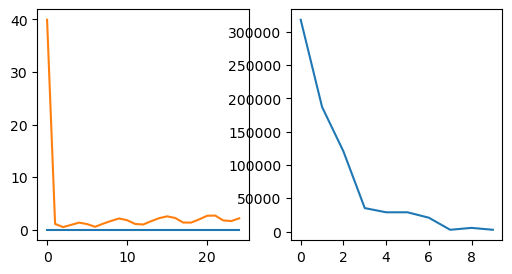

In [8]:
for _ in range(10):
    error_rate.append(0)
    for epoch in range(100):
        inps = shuffled_inputs[cycle]
        targs = shuffled_targets[cycle]

        w = np.zeros((len(inps[0]),len(inps[0][0])))
        layers = [[np.tanh((w @ wh) + (inps[0] @ wi))]] 
        for n in range(1,len(inps)):
            layers[0].append(np.tanh((layers[0][-1] @ wh) + (inps[n] @ wi)))
            
        layers.append(sig(layers[0] @ wo))

        # backward 
        oerr = (layers[1][-1]-targs[-1])*sig_der(layers[0][-1] @ wo)
        herr = (oerr @ wo.T) * tanh_der((layers[0][-2] @ wh) + (inps[-1] @ wi))
        
        ograd = np.einsum('ab,ac->bc',layers[0][-1],oerr)
        hgrad = np.einsum('ab,ac->bc',layers[0][-2],herr)
        igrad = np.einsum('ab,ac->bc',inps[-1],herr)

        for p in range(2,len(inps)):
            oerr = (layers[1][-p]-targs[-p])*sig_der(layers[0][-p] @ wo)
            herr = ((herr @ wh.T) + (oerr @ wo.T)) * tanh_der((layers[0][-(1+p)] @ wh) + (inps[-p] @ wi))

            ograd = ograd + np.einsum('ab,ac->bc',layers[0][-p],oerr)
            hgrad = hgrad + np.einsum('ab,ac->bc',layers[0][-(1+p)], herr)
            igrad = igrad + np.einsum('ab,ac->bc',inps[-p], herr)

        oerr = (layers[1][0]-targs[0])*sig_der(layers[0][0] @ wo)
        herr = ((herr @ wh.T) + (oerr @ wo.T)) * tanh_der((w @ wh) + (inps[0] @ wi))

        ograd = ograd + np.einsum('ab,ac->bc',layers[0][0],oerr)
        hgrad = hgrad + np.einsum('ab,ac->bc',w, herr)
        igrad = igrad + np.einsum('ab,ac->bc',inps[0], herr)

        # step
        wi = wi - igrad*lr
        wh = wh - hgrad*lr
        wo = wo - ograd*lr
        error_rate[-1] += np.sum([np.sum(l-t) for l,t in zip(layers[1],targs)])
        cycle = (cycle+1)%len(shuffled_inputs)

w = np.zeros((len(inputs[0]),len(inputs[0][0])))
layers = [[np.tanh((w @ wh) + (inputs[0] @ wi))]]
    
for q in range(1,len(inputs)):
    layers[0].append(np.tanh((layers[0][-1] @ wh) + (inputs[q] @ wi)))
layers.append(sig(layers[0] @ wo))
    
current_error = np.array([np.sum(l-t) for l,t in zip(layers[1],targets)])
print(f"total errors through time: {np.sum(current_error)}")

print(text[window:])
#print(''.join([check[np.argmin(np.abs(np.sum(v_data - n, 1)))][0] for n in layers[1][-1]]))
print(''.join([list(enumerate(letters))[np.argmax(n)][1] for n in layers[1][-1]]))

fig, axs = plt.subplots(1,2, figsize=(6, 3))
axs[0].plot(np.array([np.zeros((window)),current_error]).T, label=["target","prediction"])
axs[1].plot(error_rate)

In [9]:
# attention
h = len(letters)
k = np.random.rand(h,h)
q = np.random.rand(h,h)
v = np.random.rand(h,h)

In [10]:
for _ in range(100):
    queries = data @ q
    keys = data @ k
    values = data @ v

    scores = queries @ keys.T

    weights = softmax(scores/keys.shape[1]**0.5, axis=1)

    attention = weights @ values

    er = attention - data
    er = weights.T @ er
    et = er @ values.T
    ek = et @ queries
    eq = et @ keys
    g = np.einsum('ab,ac->bc',data,er)
    egk = np.einsum('ab,ac->bc',data,ek)
    egq = np.einsum('ab,ac->bc',data,eq)
    v = v - lr*g
    k = k - lr*egk
    q = q - lr*egq

    check = np.array(list(dict(zip(text,attention)).items()))
    v_data = np.array([n[1] for n in check])

/tmp/ipykernel_2294/2755699017.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  check = np.array(list(dict(zip(text,attention)).items()))


2nd

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# torch it
text_data = "dogs like hogs. frogs like logs. bogs like fog."
window = 5
text = window*"_" + text_data
letters = {letter:np.eye(len(set(text)))[index] for index,letter in enumerate(set(text))}
data = np.array([letters[n] for n in text])

window_size = window
batch_size = (len(text_data)//window)+1
letter_size = len(letters)


inputs = []
targets = []
for n in range(window):
    inputs.append(data[n:n-window-1])
    targets.append(data[n+1:n-window])
    
# shuffled data in batches of 10
shuff = np.random.choice(np.arange(len(inputs[0])), size=len(inputs[0]), replace=False)
shuffled_inputs = np.array([np.array([[t[shuff[n]] for n,_ in enumerate(t)] for t in inputs])[:,n*batch_size:n*batch_size+batch_size] for n in range(0,len(inputs[0])//batch_size)])
shuffled_targets = np.array([np.array([[t[shuff[n]] for n,_ in enumerate(t)] for t in targets])[:,n*batch_size:n*batch_size+batch_size] for n in range(0,len(targets[0])//batch_size)])

scale = 0.0001
wi = (torch.rand(letter_size, letter_size)*scale).requires_grad_()
bi = (torch.rand(letter_size,)*scale).requires_grad_()
wh = (torch.rand(letter_size, letter_size)*scale).requires_grad_()
bh = (torch.rand(letter_size,)*scale).requires_grad_()
wo = (torch.rand(letter_size, letter_size)*scale).requires_grad_()
bo = (torch.rand(letter_size,)*scale).requires_grad_()

shuffled_inputs = torch.Tensor(np.array([np.array([[t[shuff[n]] for n,_ in enumerate(t)] for t in inputs])[:,n*batch_size:n*batch_size+batch_size] for n in range(0,len(inputs[0])//batch_size)]))
shuffled_targets = torch.Tensor(np.array([np.array([[t[shuff[n]] for n,_ in enumerate(t)] for t in targets])[:,n*batch_size:n*batch_size+batch_size] for n in range(0,len(targets[0])//batch_size)]))
h = torch.zeros((batch_size,letter_size))

optimizer = torch.optim.RMSprop([wi,wh,wo], lr=.0232929922807541)

In [113]:
inputs = torch.Tensor(inputs)
targets = torch.Tensor(targets)

full_h = torch.zeros((len(inputs[0]),letter_size))
full_hidden = torch.zeros((2,window_size,len(inputs[0]),letter_size))

error_rate = []

print(inputs.shape)
print(targets.shape)
print(shuffled_inputs.shape)
print(shuffled_targets.shape)

torch.Size([5, 46, 15])
torch.Size([5, 46, 15])
torch.Size([4, 5, 10, 15])
torch.Size([4, 5, 10, 15])


dogs like hogs. frogs like logs. bogs like fog.
_ogs like hogs  hrogs like hogs  hogs like hrg


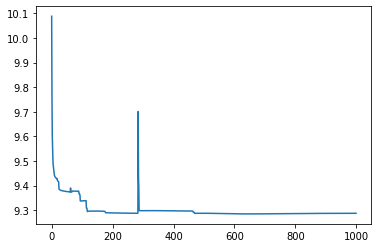

In [114]:
cycle = 0
for _ in range(1000):
    for epoch in range(batch_size):
        hidden_steps = torch.zeros((2,window_size,batch_size,letter_size))
        inps = shuffled_inputs[cycle]
        targs = shuffled_targets[cycle]

        # feed forward
        hidden_steps[0][0] = torch.tanh((h.clone() @ wh.clone() + bh.clone())+(inps[0].clone() @ wi.clone() + bi.clone()))
        hidden_steps[1][0] = torch.sigmoid(hidden_steps[0][0].clone() @ wo.clone() + bo.clone())
        for n in range(1,window_size):
            hidden_steps[0][n] = torch.tanh((hidden_steps[0][n-1].clone() @ wh.clone() + bh.clone())+(inps[n].clone() @ wi.clone() + bi.clone()))
            hidden_steps[1][n] = torch.sigmoid(hidden_steps[0][n].clone() @ wo.clone() + bo.clone())

        # backprop
        optimizer.zero_grad()
        loss = F.cross_entropy(hidden_steps[1],targs)
        loss.backward(gradient=loss, retain_graph=True)
        optimizer.step()

        cycle = (cycle+1)%len(shuffled_inputs)

    full_hidden[0][0] = torch.tanh((full_h @ wh + bh)+(inputs[0] @ wi + bi))
    full_hidden[1][0] = torch.sigmoid(full_hidden[0][0] @ wo + bo)
    for n in range(1,window_size):
        full_hidden[0][n] = torch.tanh((full_hidden[0][n-1] @ wh + bh)+(inputs[n] @ wi + bi))
        full_hidden[1][n] = torch.sigmoid(full_hidden[0][n] @ wo + bo)
    error_rate.append(torch.nn.CrossEntropyLoss()(full_hidden[1],targets))

print(text[window:])
print(''.join([list(enumerate(letters))[torch.argmax(n)][1] for n in full_hidden[1][-1]]))

plt.plot(error_rate)

3rd

In [11]:
text_data = "dogs like hogs. frogs like logs. bogs like fog. And this sentence can be as long as it needs to."
window = 11
text = (window-1)*"_" + text_data
indices = list(set(text))
letters = {letter:index for index,letter in enumerate(indices)}
data = [letters[n] for n in text]
x, y = zip(*[(data[index:index+window-1],data[index+window-1]) for index,_ in enumerate(text_data)])
inputs = torch.tensor(x)
targets = torch.tensor(y)

In [12]:
# embeddings
emb_size = 10
scale = 0.001
C = torch.randn((inputs.shape[0],emb_size))
wi = torch.rand((window-1)*emb_size, 200)/((window-1)*emb_size)**0.5
bi = torch.rand(200,)*scale
wo = torch.rand(200, inputs.shape[0])/200**0.5
bo = torch.rand(inputs.shape[0],)*scale*0


p = [wi,bi,wo,bo]
for param in p:
    param.requires_grad = True

In [13]:
# torch.cat([emb[:, n] for n in range(window)],1)
# torch.cat(torch.unbind(emb,1),1)
# emb.view(-1,10)

#counts = h2.exp()
#prob = counts / counts.sum(1, keepdims=True)
#-prob[torch.arange(inputs.shape[0]), targets].log().mean()

In [14]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

#lri = []
lossi = []
stepi = []

In [15]:
for i in range(10000):
    # minibatch
    batch = torch.randint(0, inputs.shape[0], (32,))
    emb = C[inputs[batch]]

    preh = emb.view(-1,(window-1)*emb_size) @ wi + bi
    #preh = bngain * (preh - preh.mean(0, keepdim=True))/ preh.std(0, keepdim=True) + bnbias
    h = torch.tanh(preh)
    h2 = h @ wo + bo
    loss = F.cross_entropy(h2, targets[batch])

    for param in p:
        param.grad = None
    loss.backward()


    lr = 0.1
    for param in p:
        param.data -= lr*param.grad
    
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())


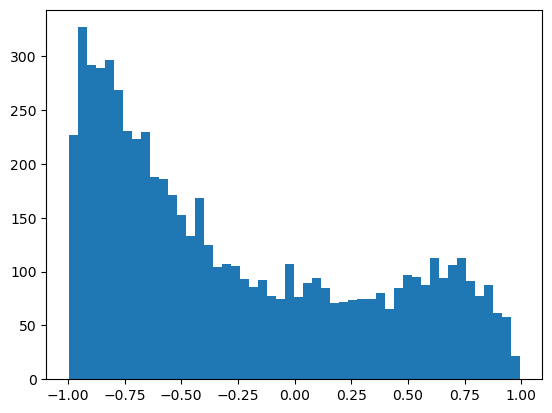

In [16]:
plt.hist(h.view(-1).tolist(), 50);

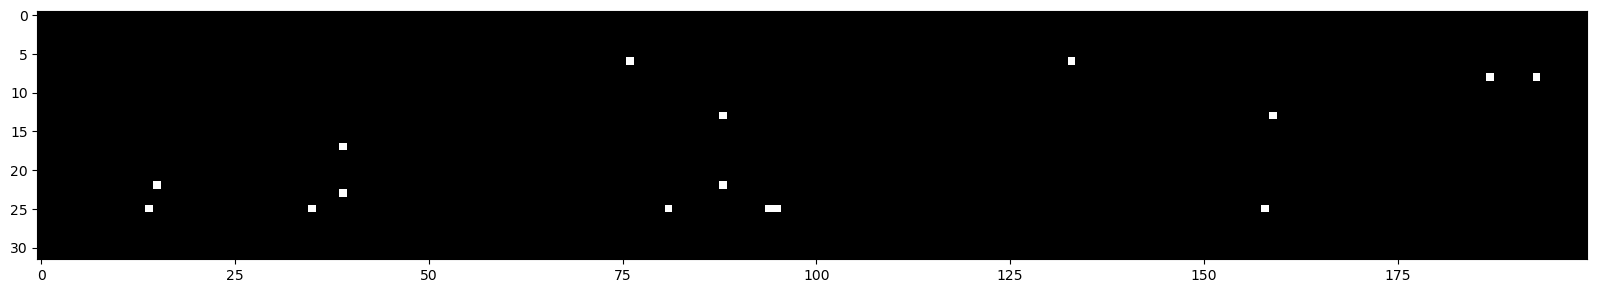

In [17]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

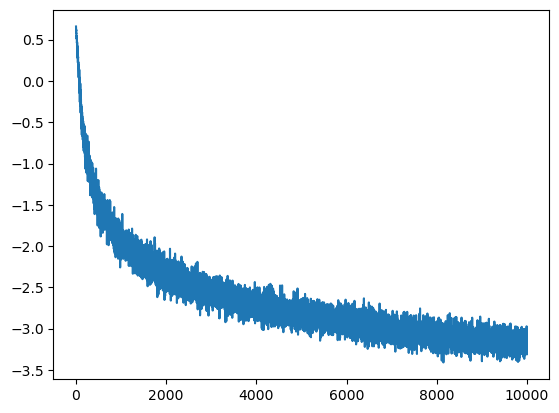

In [18]:
plt.plot(lossi)

In [19]:
emb = C[inputs]
h = torch.tanh(emb.view(-1,(window-1)*emb_size) @ wi + bi)
h2 = h @ wo + bo
loss = F.cross_entropy(h2, targets)
print(h2.max(1)[1] - targets)
print(loss)
print(''.join([indices[t] for t in h2.max(1)[1]]))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor(0.0007, grad_fn=<NllLossBackward0>)
dogs like hogs. frogs like logs. bogs like fog. And this sentence can be as long as it needs to.


In [20]:
targets

tensor([10,  5,  3, 18, 16,  2, 14,  7,  9, 16, 13,  5,  3, 18, 17, 16,  6,  8,
         5,  3, 18, 16,  2, 14,  7,  9, 16,  2,  5,  3, 18, 17, 16,  4,  5,  3,
        18, 16,  2, 14,  7,  9, 16,  6,  5,  3, 17, 16,  0, 15, 10, 16, 11, 13,
        14, 18, 16, 18,  9, 15, 11,  9, 15,  1,  9, 16,  1, 12, 15, 16,  4,  9,
        16, 12, 18, 16,  2,  5, 15,  3, 16, 12, 18, 16, 14, 11, 16, 15,  9,  9,
        10, 18, 16, 11,  5, 17])

In [21]:
h2.max(1)

torch.return_types.max(
values=tensor([ 9.7172, 11.2548, 12.3105, 13.7233, 13.6234, 12.0670, 12.8583, 12.4531,
        14.7285, 15.2938, 10.3867, 13.9351, 16.1457, 15.3681, 13.6466, 15.6306,
        13.0583, 11.5925, 11.9224, 14.8350, 14.8364, 13.4004, 13.9250, 13.7229,
        12.2376, 13.5600, 15.2663, 11.6318, 15.6990, 15.4437, 13.6046, 14.8618,
        15.1875, 11.8898, 13.5928, 14.9800, 15.5750, 19.6979, 12.9029, 13.9638,
        12.8568, 14.4118, 15.7612, 11.5773, 16.0208, 15.9773, 13.0253, 14.3820,
        10.1960, 12.1617, 12.6384, 14.4508, 11.9359, 11.0809, 11.6421, 12.7322,
        16.2726, 13.0725, 11.9585, 13.0323, 12.0387, 12.4998, 13.8597, 13.7626,
        14.2194, 15.6587, 14.6366, 13.1030, 13.8396, 15.9849, 12.6030, 15.0438,
        17.2024, 13.9124, 15.6695, 18.1202, 13.9599, 14.7568, 14.4076, 15.6081,
        17.1650, 12.5756, 13.8348, 14.5865, 12.1569, 13.2455, 13.7808, 12.1275,
        13.2349, 14.3580, 13.1752, 14.5997, 14.9174, 13.0043, 13.4062, 12.9331],
       g

4th

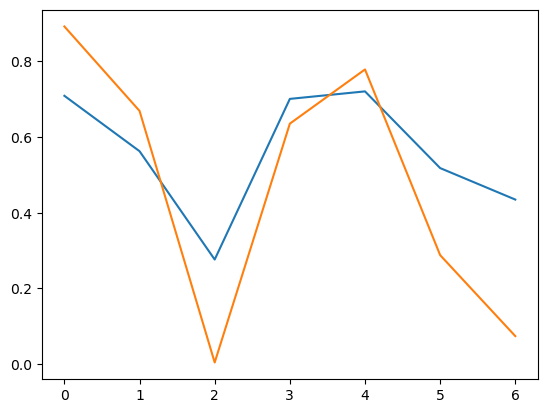

In [22]:
# n-armed bandit
input_values = 1
output_values = 7

# random probability distributions for training data
inputs = torch.eye(input_values)
target_distribution = torch.tensor(np.random.random_sample((output_values,))).float()

# single layer vanilla NN
weights = torch.rand(len(inputs),len(target_distribution)).requires_grad_()
optimizer = torch.optim.SGD([weights], lr=0.1)

def sample_distribution(true_distribution):
    return torch.ceil(true_distribution-np.random.random_sample((len(true_distribution),))).float()

# fitting target distribution in 50 epochs based on random samples (n-armed bandit)
for _ in range(50):
    optimizer.zero_grad()
    target = sample_distribution(target_distribution)
    pred = torch.sigmoid(inputs @ weights)
    loss = pred - target * torch.log(pred)
    loss.backward(gradient=torch.ones(len(inputs),len(target_distribution)))
    optimizer.step()

# target = orange; prediction = blue
results = np.array([pred[0].detach().numpy(),target_distribution.detach().numpy()]).T
plt.plot(results)

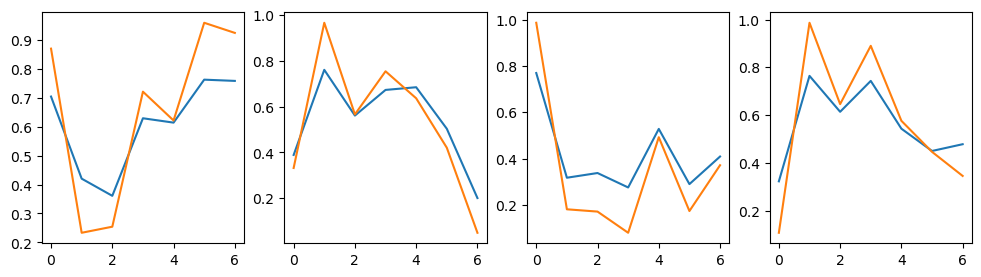

In [23]:
# contextual bandit
input_values = 4
output_values = 7

# random probability distributions for training data
inputs = torch.eye(input_values)
target_distributions = torch.rand(input_values,output_values)

# single layer vanilla NN
weights = torch.rand(input_values,output_values).requires_grad_()
optimizer = torch.optim.SGD([weights], lr=0.2)

def sample_distribution(true_distribution):
    return torch.ceil(true_distribution-torch.rand(len(true_distribution),len(true_distribution[0]))).float()

for _ in range(50):
    optimizer.zero_grad()

    # get samples/targets
    targets = sample_distribution(target_distributions)

    # feed forward
    pred = torch.sigmoid(inputs @ weights)

    # backprop
    loss = pred - targets * torch.log(pred)
    loss.backward(gradient=torch.ones(input_values,output_values))
    optimizer.step()

fig, axs = plt.subplots(1,input_values, figsize=(3*input_values, 3))
for index,item in enumerate(axs):
    item.plot(np.array([pred[index].detach().numpy(),target_distributions[index].numpy()]).T)

In [24]:
board = 64
king = 9

states = torch.eye(board)
rewards = torch.zeros(64)
rewards[0] = 1.0
moves = torch.tensor([
        [1,1],[1,0],[1,-1],
        [0,1],[0,0],[0,-1],
        [-1,1],[-1,0],[-1,-1]]).float()

weights = torch.rand(board,king).requires_grad_()
biases = torch.rand(king,).requires_grad_()
optimizer = torch.optim.SGD([weights,biases], lr=0.1)

def valid_move(x, h):
    return (
        x + h[0] + h[1]*8
        if (0 <= (x + h[0] + h[1]*8) < board) and ((x%8) == ((x + h[1]*8)%8)) and (torch.div(x,8, rounding_mode='trunc') == torch.div((x + h[0]),8, rounding_mode='trunc'))
        else x
        )
        
def valid_step(q,p):
    policies = torch.sigmoid(p @ weights + biases)
    choices = torch.tensor([prob.multinomial(num_samples=1) for prob in policies]).long()
    valid = torch.tensor([valid_move(n,choice) for n,choice in zip(q,moves[choices])]).long()
    return choices, valid

def samples(sts,t):
    v = [[valid_step((torch.zeros(board)+4).long(),states)[0],torch.arange(board)]]
    reward = [torch.sum(rewards[torch.tensor([[int(valid_move(n,m)) for m in moves] for n in v[-1][1]])],1).reshape((board,1))*torch.eye(king)[v[-1][0]]]

    for i in range(t):
        v.append(valid_step(v[-1][1],states[v[-1][1]]))
        reward.append(torch.sum(rewards[torch.tensor([[int(valid_move(n,m)) for m in moves] for n in v[-1][1]])],1).reshape((board,1))*torch.eye(king)[v[-1][0]] * (0.95**(i+1)))

    return reward[-1]


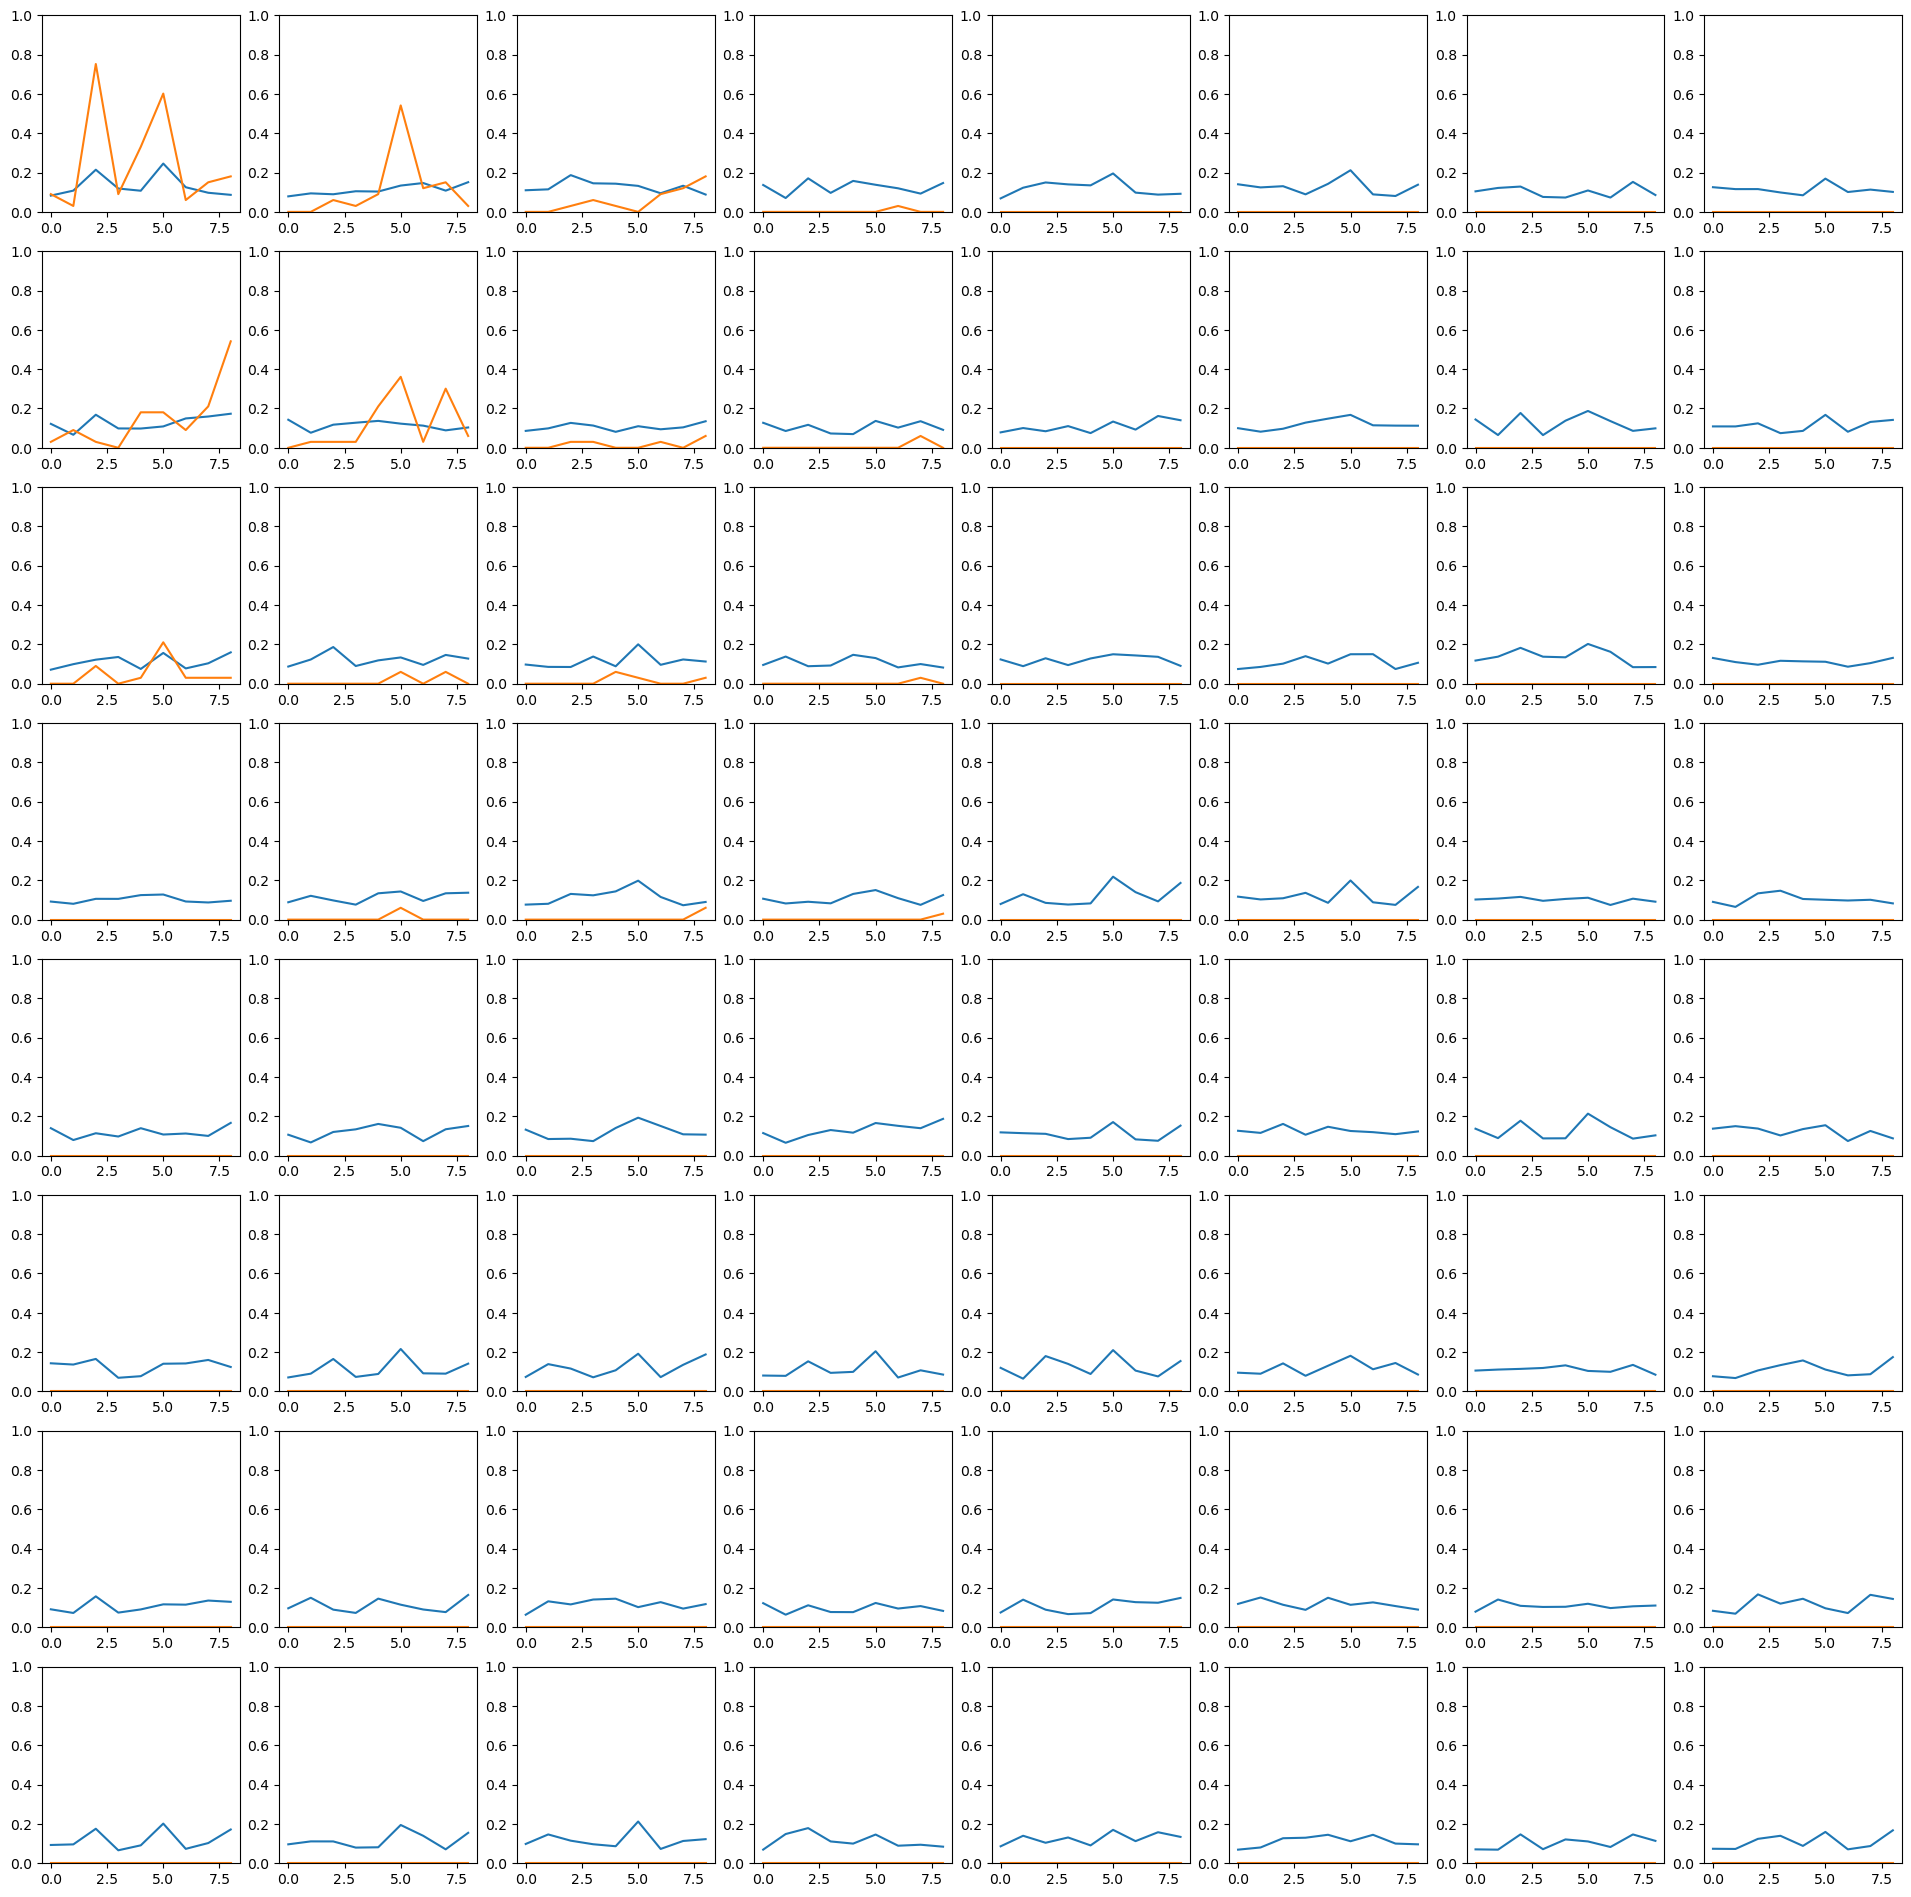

In [25]:

for _ in range(1):
    # get samples/targets
    targets = torch.mean(torch.stack([samples(states,2) for _ in range(30)]),0)
    x = states
    y = targets

    # training loop
    for _ in range(10):
        optimizer.zero_grad()

        # feed forward
        pred = torch.sigmoid(x @ weights + biases)

        # backprop
        loss = pred - y * torch.log(pred)
        loss.backward(gradient=loss)
        optimizer.step()

fig, axs = plt.subplots(8,8, figsize=(3*8, 3*8))
count = 0
for index in range(8):
    for index2 in range(8):
        axs[index][index2].set_ylim(0,1)
        axs[index][index2].plot(np.array([torch.sigmoid(states @ weights + biases)[count].detach().numpy(),y[count].detach().numpy()]).T)
        count += 1